# INFO257 Trabajo 1: Modelos de Clasificación Supervisada 
## Nombre: Ignacio Castro
#### Dataset: Analisis Sloan Digital Sky Survey DR14
    


## Nota: 
## Para mostrar como afecta el mal procesamiento del dataset a los modelos, entrenameremos los 3 modelos 3 veces, una vez antes de equilibrar el dataset, luego una vez con el dataset equilibrado pero con variables que no son indicadoras de la clase del objeto, y finalmente con el dataset equilibrado y con las variables extras removidas.

## Primero importamos la base de datos y las librerias que usaremos.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import sklearn

from pandas import Series, DataFrame
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
space = pd.read_csv("datos/SDSS-DR14.csv")
space.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


<b>DESCRIPCIONES VARIABLES</b>

objid - Identificador de la fotografia<br>
ra y dec - Angulos del telescopio<br>
u,g,r,i,z - Respuesta de las bandas del telescopio a la luz en la escala de Thuan-Gunn<br>
run - Numero del escaneo<br>
rerun - Como se proceso la imagen<br>
camcol - Columna de la camara<br>
field - Numero de campo<br>
specobjid - Identificador del objeto<br>
class - Clase del objeto<br>
redshift - redshift del objeto<br>
plate - numero de placa<br>
mjd - fecha juliana de la observacion<br>
fibedid - Identificador de la fibra<br>

## Observación
Estas características no tienen mucho sentido para predecir la clase objeto. Son en su mayoria datos referentes a la identificación del objeto, los ángulos del telescopio, la posicion, y datos de la camara. Los únicos que podrian tener relacion son las reaccion de las bandas del telescopio al flujo de luz (u,g,r,i,z) y el redshift, que indica si se esta acercando o alejando de la Tierra. Entonces, mientras es posible entrenar los modelos para que generen respuestas correctas probablemente no sean generalizables a otros problemas similares. Aun asi realizamos el análisis con los datos extras primero, para propósitos de aprendisaje.

In [2]:
#Primero vemos si hay valores nulos.
space.isnull().sum()

objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64

Como vemos que no hay datos nulos, procedemos a ver si el dataset esta equilibrado.

In [3]:
#Vemos si hay desequilibrio
space["class"].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

Hay un claro desequilibrio en cuanto a la cantidad de QSO, esto lo arreglaremos despues pero de momento lo dejaremos asi para ver como afecta a los modelos.

In [4]:
#Vemos los tipos.
space.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
objid        10000 non-null float64
ra           10000 non-null float64
dec          10000 non-null float64
u            10000 non-null float64
g            10000 non-null float64
r            10000 non-null float64
i            10000 non-null float64
z            10000 non-null float64
run          10000 non-null int64
rerun        10000 non-null int64
camcol       10000 non-null int64
field        10000 non-null int64
specobjid    10000 non-null float64
class        10000 non-null object
redshift     10000 non-null float64
plate        10000 non-null int64
mjd          10000 non-null int64
fiberid      10000 non-null int64
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


In [5]:
#Como hay un valor no numérico lo pasamos a numerico.
classdict =	{
    "STAR": 0,
    "GALAXY": 1,
    "QSO": 2
}

def classnum(g):
    return classdict[g]

space['class'] = space['class'].apply(classnum)
space.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,0,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,0,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,1,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,0,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,0,0.000590,3306,54922,512


In [6]:
#Comprobamos que ahora sea todo numerico.
space.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
objid        10000 non-null float64
ra           10000 non-null float64
dec          10000 non-null float64
u            10000 non-null float64
g            10000 non-null float64
r            10000 non-null float64
i            10000 non-null float64
z            10000 non-null float64
run          10000 non-null int64
rerun        10000 non-null int64
camcol       10000 non-null int64
field        10000 non-null int64
specobjid    10000 non-null float64
class        10000 non-null int64
redshift     10000 non-null float64
plate        10000 non-null int64
mjd          10000 non-null int64
fiberid      10000 non-null int64
dtypes: float64(10), int64(8)
memory usage: 1.4 MB


Ahora el dataset esta listo para ser procesado.

In [7]:
#Dividimos los parametros y nuestras clases.
parname=list(space.columns)
parname.remove("class")
X = space[parname].to_numpy()
Y = space["class"].to_numpy()

In [8]:
#Hacemos le muestreo para entrenamiento y testeo.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state=25)

### Primero probaremos el rendimiento de los modelos con el dataset desequilibrado, para ver como los afecta esto.

In [9]:
#Probamos el rendimiento del arbol de decision.
from sklearn import tree
tclf = tree.DecisionTreeClassifier()
tclf.fit(X_train,Y_train)
tree_pred = tclf.predict(X_test)
tree_matrix = confusion_matrix(Y_test, tree_pred)
print(tree_matrix)
print(classification_report(Y_test, tree_pred))

[[1291    7    2]
 [   2 1438   13]
 [   0   30  217]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1300
           1       0.97      0.99      0.98      1453
           2       0.94      0.88      0.91       247

   micro avg       0.98      0.98      0.98      3000
   macro avg       0.97      0.95      0.96      3000
weighted avg       0.98      0.98      0.98      3000



##### El árbol de decisión tiene un buen rendimiento, tiene buena precisión para los tres casos, es decir, si dice que un caso pertenece a cierta clase, es probable que este correcto. Tambien presenta un buen recall, o capacidad para identificar los casos (es decir, de los casos que pertenecen a una clase, cuantos el modelo reconoce que pertenecen a esa clase). Ambas medidas son un poco peores para la clase QSO, probablemente debido a la baja frecuencia de esta clase.

In [10]:
#Probamos el rendimiento de un random forest.
from sklearn.ensemble import RandomForestClassifier
fclf = RandomForestClassifier(n_estimators=10)
fclf.fit(X_train,Y_train)
forest_pred = fclf.predict(X_test)
forest_matrix = confusion_matrix(Y_test, forest_pred)
print(forest_matrix)
print(classification_report(Y_test, forest_pred))

[[1297    3    0]
 [   4 1442    7]
 [   0   29  218]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1300
           1       0.98      0.99      0.99      1453
           2       0.97      0.88      0.92       247

   micro avg       0.99      0.99      0.99      3000
   macro avg       0.98      0.96      0.97      3000
weighted avg       0.99      0.99      0.99      3000



##### El random forest tiene mejor rendimiento que el arbol de decision, lo que tiene sentido considerando que el random forest es el promedio de varios arboles de desicion.

In [11]:
#Probamos el rendimiento de la regresion linear.
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, Y_train)
logreg_pred = LogReg.predict(X_test)
logreg_matrix = confusion_matrix(Y_test, logreg_pred)
print(logreg_matrix)
print(classification_report(Y_test, logreg_pred))

[[ 971  329    0]
 [  32 1421    0]
 [  50  197    0]]
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      1300
           1       0.73      0.98      0.84      1453
           2       0.00      0.00      0.00       247

   micro avg       0.80      0.80      0.80      3000
   macro avg       0.55      0.57      0.55      3000
weighted avg       0.75      0.80      0.76      3000



##### Podemos ver que la regresión logística funciona muy mal en un dataset desequilibrado. Es completamente incapaz de identificar un QSO, e incluso se vieron afectados la precision y recall para las otras clases. Aumento la probabilidad de que clasifique erroneamente como galaxia un caso, y tiene mas dificultad para reconocer estrellas.

##### De hecho, viendo la matriz de confusion, el algoritmo se entreno para no decir nunca que un caso pertenece a la clase QSO.

### Ahora que vimos como funciona con el dataset desequilibrado, procederemos a equilibrarlo y probar nuevamente, pero sin eliminar aun los parametros que sobran. Usaremos Up-Sampling o Oversampling.

In [12]:
from sklearn.utils import resample
#Cambiamos el nombre de la columna porque al llamarse "class" causa problemas de syntax.
space2=space.rename(columns={"class": "clase"})
# Separamos el dataset en los casos mayoritarios y minoritarios.
df_major = space2[space2.clase<2]
df_minor = space2[space2.clase==2]
#Para numero de samples usamos el promedio de los otros 2 casos.
numsamples=(int)(np.sum(df_major['clase'].value_counts())/2)

In [13]:
#Hacemos up-sampling del caso minoritario.
df_minor_upsampled = resample(df_minor, 
                                 replace=True,
                                 n_samples=numsamples,
                                 random_state=123)
 
#Combinamos los casos mayoritarios con el nuevo minoritario.
df_upsampled = pd.concat([df_major, df_minor_upsampled])
 
#Comprobamos que hora este balanceado.
df_upsampled.clase.value_counts()

1    4998
2    4575
0    4152
Name: clase, dtype: int64

### Ahora que el dataset esta balanceado, repetimos los pasos anteriores para entrenamiento de modelos.

In [14]:
#Dividimos los parametros y nuestras clases.
parname=list(df_upsampled.columns)
parname.remove("clase")
X = df_upsampled[parname].to_numpy()
Y = df_upsampled["clase"].to_numpy()

In [15]:
#Hacemos le muestreo para entrenamiento y testeo.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state=25)

In [16]:
#Probamos el rendimiento del arbol de decision.
from sklearn import tree
tclf = tree.DecisionTreeClassifier()
tclf.fit(X_train,Y_train)
tree_pred = tclf.predict(X_test)
tree_matrix = confusion_matrix(Y_test, tree_pred)
print(tree_matrix)
print(classification_report(Y_test, tree_pred))

[[1229    0    0]
 [   3 1498   18]
 [   0    4 1366]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1229
           1       1.00      0.99      0.99      1519
           2       0.99      1.00      0.99      1370

   micro avg       0.99      0.99      0.99      4118
   macro avg       0.99      0.99      0.99      4118
weighted avg       0.99      0.99      0.99      4118



##### Podemos que al equilibrar el dataset, mejora levemente el rendimiento del arbol de decisión.

In [17]:
#Probamos el rendimiento de un random forest.
from sklearn.ensemble import RandomForestClassifier
fclf = RandomForestClassifier(n_estimators=10)
fclf.fit(X_train,Y_train)
forest_pred = fclf.predict(X_test)
forest_matrix = confusion_matrix(Y_test, forest_pred)
print(forest_matrix)
print(classification_report(Y_test, forest_pred))

[[1228    1    0]
 [   9 1498   12]
 [   0    4 1366]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1229
           1       1.00      0.99      0.99      1519
           2       0.99      1.00      0.99      1370

   micro avg       0.99      0.99      0.99      4118
   macro avg       0.99      0.99      0.99      4118
weighted avg       0.99      0.99      0.99      4118



##### El random forest, como el arbol de desicion, tambien presenta mejora en todas las medidas de precision y recall.

In [18]:
#Probamos el rendimiento de la regresion linear.
from sklearn.linear_model import LogisticRegression
#Configuramos logreg para funcionar con multiples clases.
LogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, Y_train)
logreg_pred = LogReg.predict(X_test)
logreg_matrix = confusion_matrix(Y_test, logreg_pred)
print(logreg_matrix)
print(classification_report(Y_test, logreg_pred))

[[ 863  303   63]
 [  40 1476    3]
 [ 253 1113    4]]
              precision    recall  f1-score   support

           0       0.75      0.70      0.72      1229
           1       0.51      0.97      0.67      1519
           2       0.06      0.00      0.01      1370

   micro avg       0.57      0.57      0.57      4118
   macro avg       0.44      0.56      0.47      4118
weighted avg       0.43      0.57      0.46      4118



##### Podemos ver un pequeño aumento en la precision y recall par objeto QSO, pero sigue siendo bastante malo. De hecho el upsampling bajo la precision y recall en los otros casos considerablemente para dar una minuscula mejora en el caso de QSO, lo que es un mal trade-off.

### Analizando el rendimiento de los modelos, podemos ver que los modelos basados en arboles como el decision tree y el random forest funcionan bien aun con datasets desequilibrados, por lo que podrían ser una buena medida para lidiar con estos. En cambio la regresión logística y otros modelos lineales sufren mucha perdida de utilidad con datasets desequilibrado. 

### De los tres modelos vistos, la regresión logística tiene la ventaja de poder predecir probabilidades y ser mas simple de entender, pues consiste solo de una serie de coeficientes, pero tiene problemas con dataset desequilibrados. El árbol de decisión es mas complejo de representar pues esta formado por varios nodos y se centra en clasificar los objetos, ademas corren el riesgo de sobreajustarse a un dataset, pero tienen un mejor rendimiento al momento de clasificar datasets, aunque esten desequilibrados. Finalmente los random forest heredan las ventajas de los árboles de decisión, y su naturaleza aleatoria ayuda a evitar el sobreajuste, pero esta aleatoridad también puede causar problemas a veces. Además al ser un conjunto de árboles de decisión, es el mas complejo de estos 3 modelos.

### Veamos cuales son las características mas importantes para la clasificación segun cada modelo:

In [19]:
#La regresion lineal con multiples categorias calcula la probabilidad para cada caso y elije la mayor.
#Por esto, habrán 3 grupos de coeficientes.
#Primero convertimos los coeficientes a valor absoluto.
logcoef0=list(map(abs, LogReg.coef_[0].tolist()))
logcoef1=list(map(abs, LogReg.coef_[1].tolist()))
logcoef2=list(map(abs, LogReg.coef_[2].tolist()))
#Luego ordenamos las variables de mayor coeficiente a menor.
plr0=[x for _,x in sorted(zip(logcoef0,parname),reverse=True)]
plr1=[x for _,x in sorted(zip(logcoef1,parname),reverse=True)]
plr2=[x for _,x in sorted(zip(logcoef2,parname),reverse=True)]
rlvalues=[plr0,plr1,plr2]

#Cuantos parametros importantes quiero que diga.
numero_parametros=10

for n,i in enumerate(["estrella","galaxia","quasar"]):
    tempst="Las caracteristicas mas importantes para que la regresion lineal decida si un objeto es {0} son en orden descendiente: ".format(i)
    for j in range(numero_parametros-1):
        tempst= tempst+rlvalues[n][j]+", "
    tempst= tempst+rlvalues[n][j+1]+"."
    print(tempst+"\n")

Las caracteristicas mas importantes para que la regresion lineal decida si un objeto es estrella son en orden descendiente: objid, specobjid, mjd, run, fiberid, plate, rerun, dec, ra, field.

Las caracteristicas mas importantes para que la regresion lineal decida si un objeto es galaxia son en orden descendiente: specobjid, objid, mjd, run, plate, fiberid, rerun, ra, dec, field.

Las caracteristicas mas importantes para que la regresion lineal decida si un objeto es quasar son en orden descendiente: specobjid, objid, mjd, run, fiberid, plate, dec, field, z, i.



##### La regresión logística se centra en valores que no deberian influir en la naturaleza del objeto, como las id, las fechas o el numero del scaneo. Es posible que el patron que se usa para asignar IDs varie segun el objeto y por eso le este asignando tanto peso.

In [20]:
#Ahora veamos las mas importantes para el árbol de decisión.
#Esto es un poco mas facil porque el arbol incluye una funcion que nos dice las variables mas importantes.
#tclf.feature_importances_
tparnam=[x for _,x in sorted(zip(tclf.feature_importances_.tolist(),parname),reverse=True)]

tempst="Las caracteristicas mas importantes para que el árbol de decisión clasifique un objeto son, en orden descendiente: "
for i in range(numero_parametros-1):
    tempst= tempst+tparnam[i]+", "
tempst= tempst+tparnam[i+1]+"."
print(tempst+"\n")

Las caracteristicas mas importantes para que el árbol de decisión clasifique un objeto son, en orden descendiente: redshift, g, u, specobjid, z, field, plate, ra, i, fiberid.



##### Se centra menos en identificadores y da mas importancia a valores de ubicacion y los niveles de luz los del objeto, que son mejores inicadores de su naturaleza.

In [21]:
#Ahora veamos las mas importantes para el random forest.
#Igualmente es más facil porque incluye una funcion que nos dice las variables mas importantes.
#fclf.feature_importances_
tparnam=[x for _,x in sorted(zip(fclf.feature_importances_.tolist(),parname),reverse=True)]

tempst="Las caracteristicas mas importantes para que el random forest clasifique un objeto son, en orden descendiente: "
for i in range(numero_parametros-1):
    tempst= tempst+tparnam[i]+", "
tempst= tempst+tparnam[i+1]+"."
print(tempst+"\n")

Las caracteristicas mas importantes para que el random forest clasifique un objeto son, en orden descendiente: redshift, r, plate, z, specobjid, i, g, mjd, u, dec.



##### Al igual que el árbol, se centra menos en identificadores y da mas importancia a valores de ubicacion y los niveles de luz de los del objeto, que son mejores inicadores de su naturaleza.

## Por último, terminaremos de arreglar el dataset y prepararlo paraa el análisis. 

### Como dijimos inicialmente la mayoria de las variables no estan asociadas el objeto observado en el cielo, sino que son identificadores del telescopio, la camara o la imagen fotográfica. Entonces ahora haremos esto usando solamente la información que pertenece al objeto celestial en si: u, g, r, i, z, que indican la luz o color que recibe el telescopio desde ol objeto en el espacio, y redshift, que es un cambio en la longitud de onda de la luz que nos indica si el objeto se esta acercando o alejando de la Tierra. 

In [22]:
parname2=["u","g","r","i","z","redshift"]
#Dividimos los parametros y nuestras clases.
X = df_upsampled[parname2].to_numpy()
Y = df_upsampled["clase"].to_numpy()
#Hacemos le muestreo para entrenamiento y testeo.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state=25)

In [23]:
#Probamos el rendimiento del arbol de decision.
from sklearn import tree
tclf = tree.DecisionTreeClassifier()
tclf.fit(X_train,Y_train)
tree_pred = tclf.predict(X_test)
tree_matrix = confusion_matrix(Y_test, tree_pred)
print(tree_matrix)
print(classification_report(Y_test, tree_pred))

[[1229    0    0]
 [   3 1500   16]
 [   0    4 1366]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1229
           1       1.00      0.99      0.99      1519
           2       0.99      1.00      0.99      1370

   micro avg       0.99      0.99      0.99      4118
   macro avg       0.99      0.99      0.99      4118
weighted avg       0.99      0.99      0.99      4118



In [24]:
#Probamos el rendimiento de un random forest.
from sklearn.ensemble import RandomForestClassifier
fclf = RandomForestClassifier(n_estimators=10)
fclf.fit(X_train,Y_train)
forest_pred = fclf.predict(X_test)
forest_matrix = confusion_matrix(Y_test, forest_pred)
print(forest_matrix)
print(classification_report(Y_test, forest_pred))

[[1229    0    0]
 [   8 1501   10]
 [   0    1 1369]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1229
           1       1.00      0.99      0.99      1519
           2       0.99      1.00      1.00      1370

   micro avg       1.00      1.00      1.00      4118
   macro avg       1.00      1.00      1.00      4118
weighted avg       1.00      1.00      1.00      4118



In [25]:
#Probamos el rendimiento de la regresion linear.
from sklearn.linear_model import LogisticRegression
#Configuramos logreg para funcionar con multiples clases.
LogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, Y_train)
logreg_pred = LogReg.predict(X_test)
logreg_matrix = confusion_matrix(Y_test, logreg_pred)
print(logreg_matrix)
print(classification_report(Y_test, logreg_pred))

[[1202   23    4]
 [  81 1427   11]
 [   0   36 1334]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1229
           1       0.96      0.94      0.95      1519
           2       0.99      0.97      0.98      1370

   micro avg       0.96      0.96      0.96      4118
   macro avg       0.96      0.96      0.96      4118
weighted avg       0.96      0.96      0.96      4118



##### Podemos apreciar que el árbol y el bosque mantienen su buen rendimiento, pero la regresion linear experimenta una masiva mejora, por lo que podemos teorizar que los modelos lineales se ven más afectado por datos inutiles que los algoritmos basados en arboles.

#### Dicho de otra manera, la regresión logistica funcionara mejor en un dataset equilibrado y con parametros que afecten la clasificación de objeto y en caso contrario no tendrá buen rendimiento.

### Ahora veamos a que parametros les dan importancia los modelos:

In [26]:
#La regresion lineal con multiples categorias calcula la probabilidad para cada caso y elije la mayor.
#Por esto, habrán 3 grupos de coeficientes.
#Primero convertimos los coeficientes a valor absoluto.
logcoef0=list(map(abs, LogReg.coef_[0].tolist()))
logcoef1=list(map(abs, LogReg.coef_[1].tolist()))
logcoef2=list(map(abs, LogReg.coef_[2].tolist()))
#Luego ordenamos las variables de mayor coeficiente a menor.
plr0=[x for _,x in sorted(zip(logcoef0,parname2),reverse=True)]
plr1=[x for _,x in sorted(zip(logcoef1,parname2),reverse=True)]
plr2=[x for _,x in sorted(zip(logcoef2,parname2),reverse=True)]
rlvalues=[plr0,plr1,plr2]

#Cuantos parametros importantes quiero que diga.
numero_parametros=len(parname2)

for n,i in enumerate(["estrella","galaxia","quasar"]):
    tempst="Las caracteristicas mas importantes para que la regresion lineal decida si un objeto es {0} son en orden descendiente: ".format(i)
    for j in range(numero_parametros-1):
        tempst= tempst+rlvalues[n][j]+", "
    tempst= tempst+rlvalues[n][j+1]+"."
    print(tempst+"\n")

Las caracteristicas mas importantes para que la regresion lineal decida si un objeto es estrella son en orden descendiente: redshift, g, z, r, u, i.

Las caracteristicas mas importantes para que la regresion lineal decida si un objeto es galaxia son en orden descendiente: redshift, r, z, g, u, i.

Las caracteristicas mas importantes para que la regresion lineal decida si un objeto es quasar son en orden descendiente: redshift, g, u, z, r, i.



##### Podemos ver que además de la mejora en precision y recall, ahora el algoritmo es mas consistente. Todas las clases le dan la mayor importancia  al redshift, mederada importancia a g y la menor importancia a i.

In [27]:
#Ahora veamos las mas importantes para el árbol de decisión.
#Esto es un poco mas facil porque el arbol incluye una funcion que nos dice las variables mas importantes.
#tclf.feature_importances_
tparnam=[x for _,x in sorted(zip(tclf.feature_importances_.tolist(),parname2),reverse=True)]

tempst="Las caracteristicas mas importantes para que el árbol de decisión clasifique un objeto son, en orden descendiente: "
for i in range(numero_parametros-1):
    tempst= tempst+tparnam[i]+", "
tempst= tempst+tparnam[i+1]+"."
print(tempst+"\n")

Las caracteristicas mas importantes para que el árbol de decisión clasifique un objeto son, en orden descendiente: redshift, u, g, z, i, r.



##### Se destaca que al igual que laa regresión logistica, el árbol le da mayor importancia al redshift.

In [28]:
#Ahora veamos las mas importantes para el random forest.
#Igualmente es más facil porque incluye una funcion que nos dice las variables mas importantes.
#fclf.feature_importances_
tparnam=[x for _,x in sorted(zip(fclf.feature_importances_.tolist(),parname2),reverse=True)]

tempst="Las caracteristicas mas importantes para que el random forest clasifique un objeto son, en orden descendiente: "
for i in range(numero_parametros-1):
    tempst= tempst+tparnam[i]+", "
tempst= tempst+tparnam[i+1]+"."
print(tempst+"\n")

Las caracteristicas mas importantes para que el random forest clasifique un objeto son, en orden descendiente: redshift, i, r, z, g, u.



##### El bosque también prioritiza el redshift.

### Entonces, podemos decir que el factor mas influyente en la clasificación sera el redshift del objeto, seguido por las varias variables de medicion de luz, que son priorizadas distinto segun el modelo usado.

## Para terminar, veamos los modelos que generamos:

In [29]:
coeficientes=LogReg.coef_
intercepts=LogReg.intercept_

for n,i in enumerate(["estrella","galaxia","quasar"]):
    tempst="La ecuación para la probabilidad de que sea {0} es:\n".format(i)
    for c,j in enumerate(parname2):
        tempst+= str(coeficientes[n][c])[:10]+"*"+j+" + "
    tempst+= str(intercepts[n])[:10]
    print(tempst+"\n")

La ecuación para la probabilidad de que sea estrella es:
3.43948927*u + -5.3678659*g + -4.6944312*r + 1.54999906*i + 5.10711507*z + -18.027158*redshift + 0.38672076

La ecuación para la probabilidad de que sea galaxia es:
0.92293654*u + -0.9504357*g + 2.50845173*r + -0.4348894*i + -1.9762455*z + 5.31835128*redshift + -2.0129575

La ecuación para la probabilidad de que sea quasar es:
-4.3624258*u + 6.31830167*g + 2.18597953*r + -1.1151096*i + -3.1308694*z + 12.7088075*redshift + 1.62623679



### Como dijimos antes, la regresión logistica es la más facil de representar. Es solo una ecuación con un intercept y un coeficiente para cada parámetro, que da como resultado una probabilidad. Para clases multiples, se elije la clase que de mayor probabilidad.

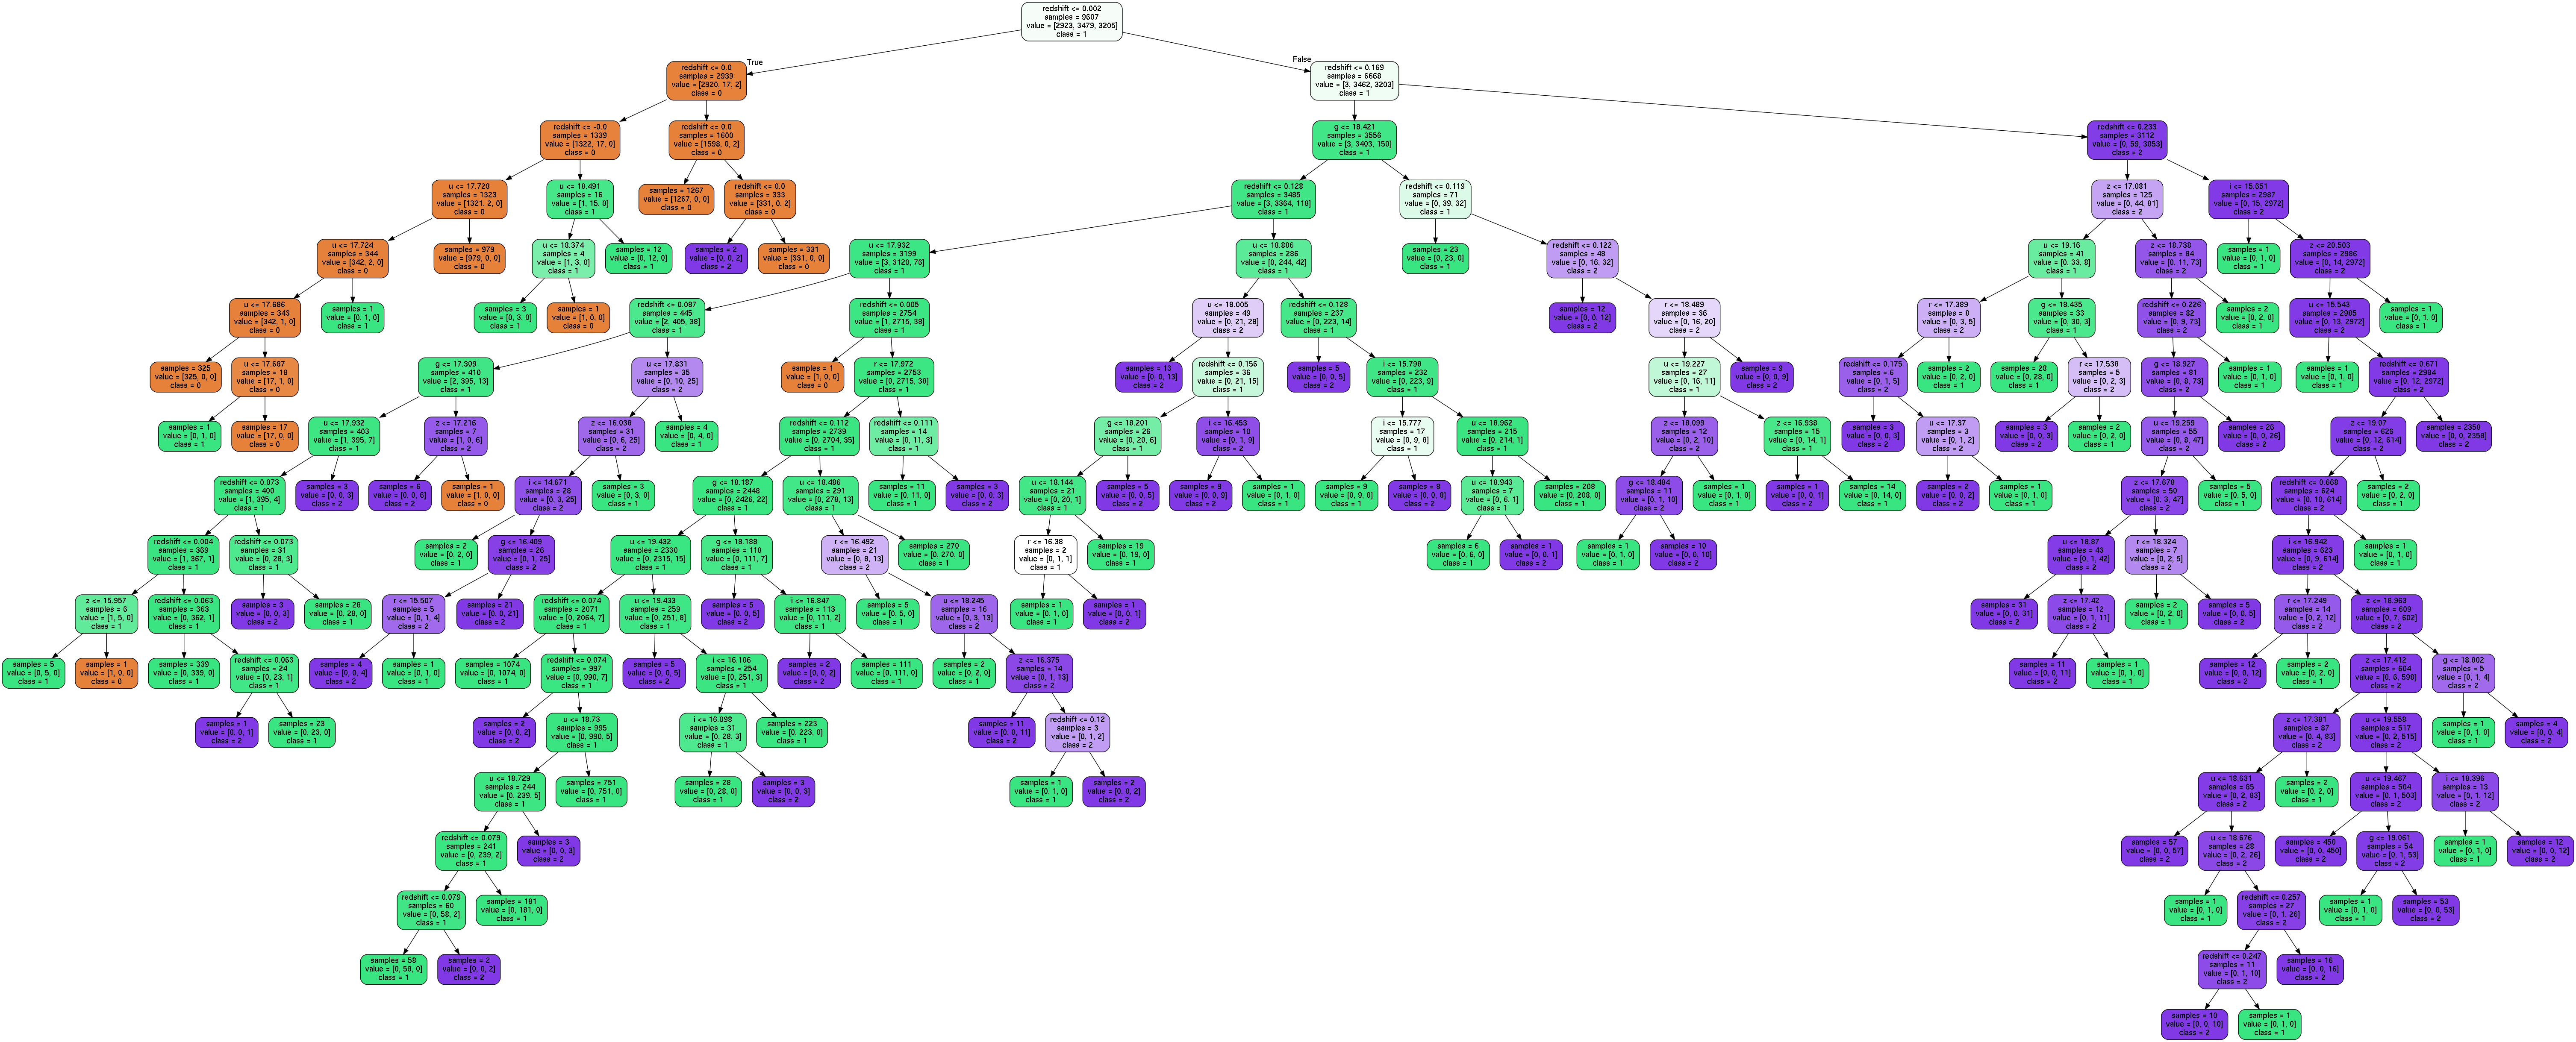

In [30]:
from sklearn.externals.six import StringIO
import pydot
from IPython.display import Image

dot_data = StringIO()

features=parname2
classes=['0','1','2']
tree.export_graphviz(tclf,out_file=dot_data,feature_names=features,class_names=classes, filled=True, 
                     rounded=True, impurity=False)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
graph[0].write_png('modelo.png')
Image(filename='modelo.png') 

### Aquí podemos ver el árbol de decisión, y podemos ver que el orden en que hace las preguntas concuerda con el orden de importancia dado anteriormente, empieza con redshift y despues pregunta por u, g, z, r, i en ese orden general.

### El Random Forest tiene una representación demasido complicada para ilustrarla, pero en general consiste en crear varios árboles de decisión con muestras al azar del dataset, luego cuando recibe un input, lo evalua en todos los árboles y lo clasifica segun decisión que tomen la mayoria de los árboles.

## Conclusiones

<i>De lo observado en este trabajo se pueden sacar algunas conclusiones:
- En este dataset el parametro más útil para diferenciar las clases es el redshift. <br>
- En un dataset desequilibrado y con parametros no relacionados a la clasificación, la regresión logística tiene mal rendimiento. <br>
- Los modelos basados en árboles tienen buen rendimiento aunque el dataset este desequilibrado. <br>
- Los árboles de decisión tienden a sobreajustarse a un dataset, los random forest intentar solucionar esto usando varios datasets muestreados al azar. <br>
- La regresión lineal es facil de representar pues es solo una ecuación. Se puede transferir facilmente a otro contexto. <br>
- Un modelo basado en árboles es complejo de representar y transferir. <br>
- Todos los modelos rindieron mejor cuando el dataset es equilibrado.<br>
- Todos los modelos rindieron mejor al descartar información no relevante.